# ADAmax Milestone 2

In this notebook we briefly describe the data. Then we present the first analysis of tvtropes effect and competition effect. Those two part are to confirm our project is doable and how we will handle our research question. At last we present our attempt to analyse the movie plots based on an NLP model.

Structure of the respository:


 - data/
      - Imdb/
      - MovieSummaries/
 - src/
      - initial_analysis.ipynb
      - helpers.py
      - preprocess.py

## The Big Flop

### Initial preprocess (only run once)

The preprocess works like this:
  - One of the movie has a released date in 1010 and that is not possible. After checking on the web, the released date was in 2010.
  - To take into account the inflation, we create the features **adj_budjet**, **adj_revenue**, ... that are the the values of budget and revenue ajusted with the inflation. 

In [153]:
# from preprocess import preprocess

# preprocess()

### Getting the data

In [184]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import ipywidgets as widgets
import geopandas

from tqdm import tqdm
from scipy.stats import bootstrap
from sklearn.decomposition import PCA
from helpers import *
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In the CMU dataset, we have basic features like revenue, movie titles, genres, etc. In the IMDb dataset, there are a lot of additional features like budget, producer information, and user ratings.

Initially, there is no common key (column to merge) for the two datasets. Fortunately, for almost all of the Freebase IDs, we were able to find corresponding IMDb IDs.

In this notebook, we only consider the merged dataset (and any of its derivations).

There are features with the same name in both datasets, but they are not identical in values. For example, the movie runtimes can be different between the two datasets.

In [194]:
# Get the movie dataframe (merged from CMU and IMDb)
df_movies = get_movies()

display(df_movies.head(3))
display(df_movies.describe())
df_movies.columns


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,title,video,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2.143713e+07,tt0228333,False,...,Ghosts of Mars,False,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Horror, Supernatural, Science Fiction, Space ...",2001.0,2001-08-24
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",NaN,tt0094320,False,...,White of the Eye,False,5.7,15.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Erotic thriller, Horror, Psychological thrill...",1987.0,1987-01-01
2,6631279,/m/0gffwj,Little city,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",NaN,tt0119548,False,...,Little City,False,6.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Comedy, Drama, Romance Film, Romantic drama, ...",1997.0,1997-04-04


,wiki_id,box_office_revenue,runtime_x,adj_revenue_x,revenue,runtime_y,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,year
count,2.601100e+04,6.953000e+03,24768.000000,6.925000e+03,2.601100e+04,25990.000000,26011.000000,26011.000000,2.591300e+04,2.591300e+04,2.591300e+04,25361.000000
mean,1.201912e+07,5.177056e+07,99.855045,9.929178e+07,1.411799e+07,97.956907,5.823440,131.700896,2.547546e+07,8.693101e+06,1.678236e+07,1985.193052
std,1.068013e+07,1.145230e+08,28.824344,2.471029e+08,6.811600e+07,31.965146,1.591846,533.528543,1.326382e+08,2.798300e+07,1.195633e+08,24.028646
min,3.217000e+03,1.000000e+04,0.000000,1.242662e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-8.363272e+08,1890.000000
25%,2.641520e+06,2.604414e+06,89.000000,8.762023e+06,0.000000e+00,88.000000,5.300000,5.000000,0.000000e+00,0.000000e+00,0.000000e+00,1970.000000
50%,8.494848e+06,1.282632e+07,97.000000,2.969312e+07,0.000000e+00,97.000000,6.100000,13.000000,0.000000e+00,0.000000e+00,0.000000e+00,1993.000000
75%,2.078840e+07,4.661621e+07,110.000000,9.379987e+07,0.000000e+00,109.000000,6.800000,48.000000,0.000000e+00,0.000000e+00,0.000000e+00,2005.000000
max,3.737388e+07,2.782275e+09,1003.000000,7.828022e+09,2.787965e+09,931.000000,10.000000,14075.000000,7.801138e+09,8.363272e+08,7.723161e+09,2016.000000


Index(['wiki_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime_x',
       'languages', 'countries', 'adj_revenue_x', 'imdb_id', 'adult',
       'belongs_to_collection', 'budget', 'homepage', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'revenue', 'runtime_y', 'spoken_languages', 'status', 'tagline',
       'title', 'video', 'vote_average', 'vote_count', 'adj_revenue_y',
       'adj_budget', 'adj_profit', 'genres', 'year', 'release_date'],
      dtype='object')

### Detection of the box-office bombs

#### Using the list from tvtropes.org

In [156]:
import tropes
# please download this file and provide a path to it before running this cell
# https://github.com/rhgarcia/tropescraper/raw/master/datasets/tvtropes_20200302.json.zip
df_tropes = tropes.merge_cmu_with_tvtropes(df_movies, tropes.get_tvtropes_movies("../data/tvtropes_20200302.json"))
df_tropes = tropes.add_bob_indicator(df_tropes)

print(f"""Among the {len(df_movies)} in the IMDb dataset, {len(df_tropes)} have trope information
({len(df_tropes)/len(df_movies)*100:.1f})%.
Out of those, {df_tropes["is_bomb_tvtropes"].sum()} are bombs (contain the trope 'BoxOfficeBomb')
({df_tropes["is_bomb_tvtropes"].sum()/len(df_tropes)*100:.1f}%).""")

df_tropes.head(3)

Among the 26011 in the IMDb dataset, 6614 have trope information
(25.4)%.
Out of those, 1351 are bombs (contain the trope 'BoxOfficeBomb')
(20.4%).


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date,trope,is_bomb_tvtropes
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2.143713e+07,tt0228333,False,...,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Horror, Supernatural, Science Fiction, Space ...",2001.0,2001-08-24,"[bigbad, takethat, deadpansnarker, unreliablev...",True
1,77856,/m/0kcn7,Mary Poppins,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",8.939626e+08,tt0058331,False,...,7.4,1217.0,8.939626e+08,5.244581e+07,8.415168e+08,"{Comedy, Drama, Musical, Children's/Family, Ch...",1964.0,1964-08-27,"[bigbad, thestraightwillandgrace, onehitwonder...",True
2,9548445,/m/02pjlrp,Archie: To Riverdale and Back Again,NaN,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",NaN,tt0099054,False,...,5.5,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Comedy, TV Movie}",1990.0,1990-05-06,"[sobaditsgood, slutshaming, shotgunwedding, co...",False


The variable `is_bomb_tvtropes` is one of the indicators of the failure of a movie. This is a good indicator as it is based on "expert opinion": tvtropes users, who has domain knowledge on the movie industry. However, we only know this information for a fraction of all the movies in our big dataset. 

#### Using the budget feature in IMDb datas

We don't really know the real revenue of the production companies for each movies. But we know a proxy of it : the box office revenue. Therefore a creteria for beeing a box office bomb can be $revenue-budget<0$

In [157]:
# Compute that criteria
df_movies["is_bomb_profit"] = df_movies["adj_profit"] < 0

print(f"""Among the {len(df_movies)} in the IMDb dataset, {df_movies["is_bomb_profit"].sum()} are bombs.
    That represents {df_movies["is_bomb_profit"].sum()/len(df_movies)*100:.1f}% of the dataset
    And {df_movies["is_bomb_profit"].sum()/len(df_movies[~df_movies["adj_profit"].isna()])*100:.1f}% of movies that we know the profit
""")


Among the 26011 in the IMDb dataset, 3312 are bombs.
    That represents 12.7% of the dataset
    And 12.8% of movies that we know the profit



#### Using the reviews in IMDb datas

We decide that a movie have bad reviews if its average review is lower than the 10% quantile of all average reviews

In [158]:
df_movies["is_bomb_reviews"] =  df_movies["vote_average"] < df_movies["vote_average"].quantile(0.1)

print(f"""Among the {len(df_movies)} in the IMDb dataset, {df_movies["is_bomb_reviews"].sum()} are bombs.
    That represents {df_movies["is_bomb_reviews"].sum()/len(df_movies)*100:.1f}% of the dataset
    And {df_movies["is_bomb_reviews"].sum()/len(df_movies[~df_movies["vote_average"].isna()])*100:.1f}% of movies that we know the average review 
""")

Among the 26011 in the IMDb dataset, 2568 are bombs.
    That represents 9.9% of the dataset
    And 9.9% of movies that we know the average review 



#### Distribution of ratings by genre

In [159]:
dict_similar = {"Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica"], 
                "LGBT": ["New Queer Cinema", "Gay", "Homoeroticism"],
                "Coming of age": ["Coming-of-age film"], "Erotica": ["Homoeroticism"], 
                "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comdedy", "Adventure Comedy", "Commedy of manners", "Workplace comedy"], 
                "Language & Literature": ["& Literature"], 
                "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama"], 
                "Documentary": ["Political Documetary", "Docudrama", "Historical Documentaries", "Rockumentary"], 
                "Social issues": ["Social problem film"], 
                "War film": ["War effort", "The Netherlands in World War II", "Gulf War", "Combat Films"],
                "Alien Film": ["Alien invasion"],
                "Animation": ["Animated cartoon"],
                "Family & Personal Relationships": ["Family Film", "Interpersonal Relationship"],
                "Gross out": ["Gross-out Film"],
                "Dance": ["Hip hop movies", "Breakdance"],
                "History": ["Historical Documentaries"],
                "Political cinema": ["Political Documentary"],
                "Science Fiction": ["Sci Fi Picture original film"],
                "Buddy film": ["Buddy Picture", "Buddy cop"],
                "Music": ["Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera"], #Should we add Musical here?
                "Animals": ["Animal Picture"],
                "Religious Film": ["Christian film", "Cult"],
                "Master Criminal Films": ["Heist", "Gangster Film"],
                "Film à clé": ["Film \\u00e0 clef"],
                "Biographical film": ["Biography", "Biopic [feature]"],
                "Beach Film": ["Beach Party film"],
                "World cinema": ["Chinese Movies", "Japanese Movies", "Latino", ""],
                "Musical": ["Singing cowboy"],
                "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
                "Television Movie": ["TV Movie"],
                "Horror": ["Natural Horror film", "Sci-fi Horror"],
                "Historical": ["British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War"],
                "Monster": ["Creature Movie", "Monster Movie", "Creature"],
            }

dict_similar_rev = dict()
for key, value in dict_similar.items():
    key = key.lower()
    for v in value:
        v = v.lower()
        dict_similar_rev[v] = key
    dict_similar_rev[key] = key

def get_genre(set_genres):
    new_genres = set()
    for g in set_genres:
        g = g.lower()
        temp = True
        for s_g in g.split(" "):
            if s_g in dict_similar_rev.keys():
                new_genres.add(dict_similar_rev[s_g])
                temp = False
        if temp:
            if g in dict_similar_rev.keys():
                new_genres.add(dict_similar_rev[g])
            else:
                new_genres.add(g)

    return new_genres

df_movies["genres"] = df_movies["genres"].apply(get_genre)

In [160]:
all_genres = set()

for genres in df_movies["genres"]:
    all_genres.update(genres)

print("We have in total", len(all_genres), "different genres")
print(all_genres)

We have in total 240 different genres
{'fan film', 'new hollywood', 'business', 'cavalry film', 'mockumentary', 'finance & investing', 'journalism', 'romance', 'action thrillers', 'escape film', 'feminist film', 'blaxploitation', 'culture & society', 'statutory rape', 'film', 'exploitation', 'documentary', 'apocalyptic and post-apocalyptic fiction', 'travel', 'revenge', 'supermarionation', 'heaven-can-wait fantasies', 'biographical film', 'bloopers & candid camera', 'americana', 'school story', 'inventions & innovations', 'comedy', 'archives and records', "children's fantasy", 'dystopia', 'sword and sandal', 'porn', 'sword and sorcery films', 'fairy tale', 'science fiction', 'kafkaesque', 'graphic & applied arts', 'adventure', 'period piece', 'western', 'sci-fi thriller', 'absurdism', 'romance film', 'hagiography', 'pre-code', 'private military company', 'epic', 'anthropology', 'sword and sorcery', 'thriller', 'tollywood', 'natural disaster', 'art film', 'juvenile delinquency film', 'p

In [161]:
# Create a column for each genre
for genre in all_genres:
    df_movies[f"is_{genre}"] = df_movies["genres"].apply(lambda x: genre in x)

In [162]:
# genre rating
genre_rates = dict()
for genre in all_genres:
    g_rates = df_movies[df_movies[f"is_{genre}"]]["vote_average"].values
    if len(g_rates) < 1000:
        continue
    ci = bootstrap([g_rates], statistic=np.mean, n_resamples=1000).confidence_interval
    genre_rates[genre] = np.mean(g_rates), ci.low, ci.high, g_rates



In [163]:
print(genre_rates["animation"])

(6.340318524727578, 6.2685666387259005, 6.406081994307508, array([6.7, 6.1, 5.4, ..., 7.5, 7. , 6.6]))


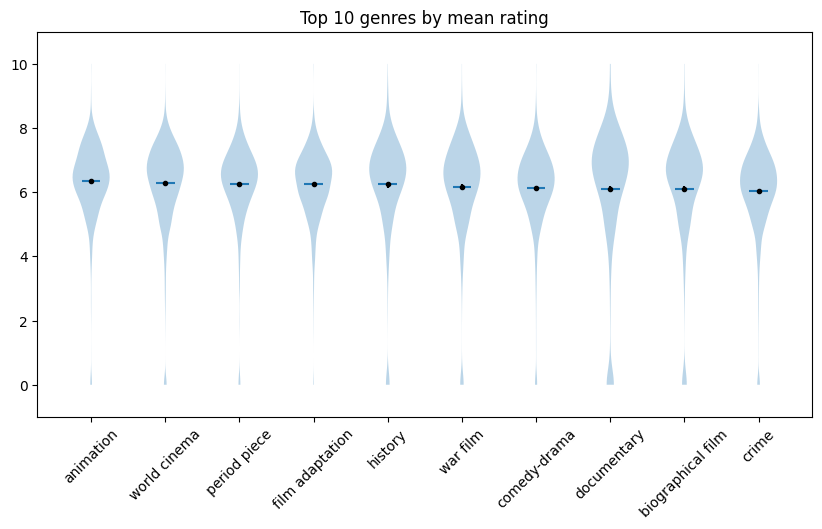

In [164]:
# Plot the top 10 genres
top10 = sorted(genre_rates.items(), key=lambda x: x[1][0], reverse=True)[:10]

plt.figure(figsize=(10, 5))
plt.violinplot([x[1][3] for x in top10], showmeans=True, showextrema=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in top10])
# plt.bar([x[0] for x in top10], [x[1][0] for x in top10])
plt.errorbar(list(range(1, 11)), [x[1][0] for x in top10], yerr=[[x[1][0]-x[1][1] for x in top10], [x[1][2]-x[1][0] for x in top10]], fmt='.', color='black')
plt.xticks(rotation=45)
plt.ylim(-1, 11)
plt.title("Top 10 genres by mean rating")
plt.show()


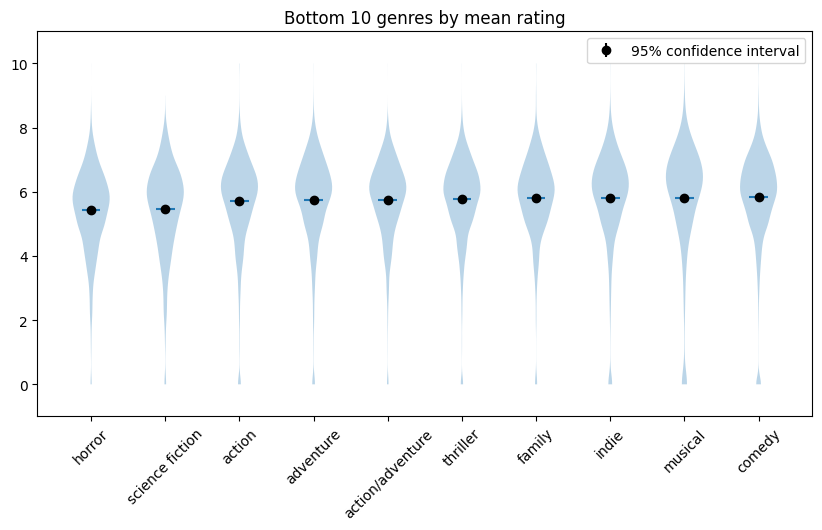

In [165]:
# Plot the bottom 10 genres
bottom10 = sorted(genre_rates.items(), key=lambda x: x[1][0], reverse=False)[:10]

plt.figure(figsize=(10, 5))
plt.violinplot([x[1][3] for x in bottom10], showmeans=True, showextrema=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in bottom10])
# plt.bar([x[0] for x in bottom10], [x[1][0] for x in bottom10], label="Average rating")
plt.errorbar(list(range(1, 11)), [x[1][0] for x in bottom10], yerr=[[x[1][0]-x[1][1] for x in bottom10], [x[1][2]-x[1][0] for x in bottom10]], fmt='o', color='black', label="95% confidence interval")
plt.xticks(rotation=45)
plt.ylim(-1, 11)
plt.title("Bottom 10 genres by mean rating")
plt.legend()
plt.show()


In [150]:
# Genre rating by year
genre_rates_by_year = dict()
for year in tqdm(range(1900, 2020)):
    genre_rates_by_year[year] = dict()
    for genre in all_genres:
        g_rates = df_movies[(df_movies[f"is_{genre}"]) & (df_movies["year"] <= year)]["vote_average"].values
        if len(g_rates) < 10:
            continue
        ci = bootstrap([g_rates], statistic=np.mean, n_resamples=1000).confidence_interval
        genre_rates_by_year[year][genre] = np.mean(g_rates), ci.low, ci.high, g_rates

100%|██████████| 120/120 [01:58<00:00,  1.01it/s]


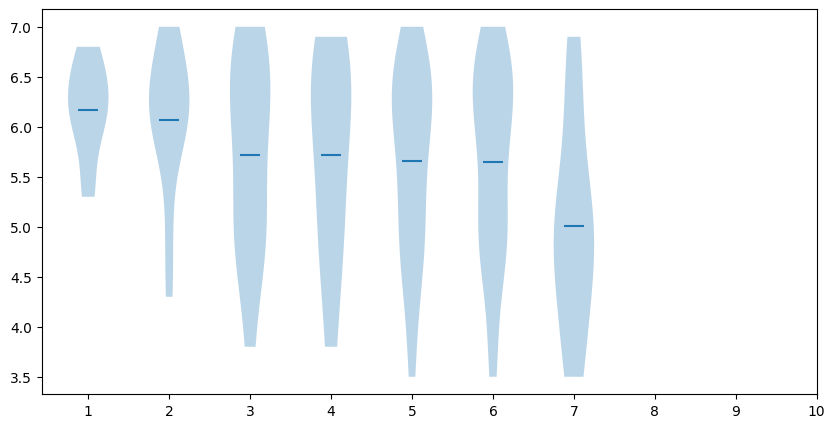

interactive(children=(IntSlider(value=1900, description='year', max=2019, min=1900), Output()), _dom_classes=(…

<function __main__.plot_top10_by_year(year)>

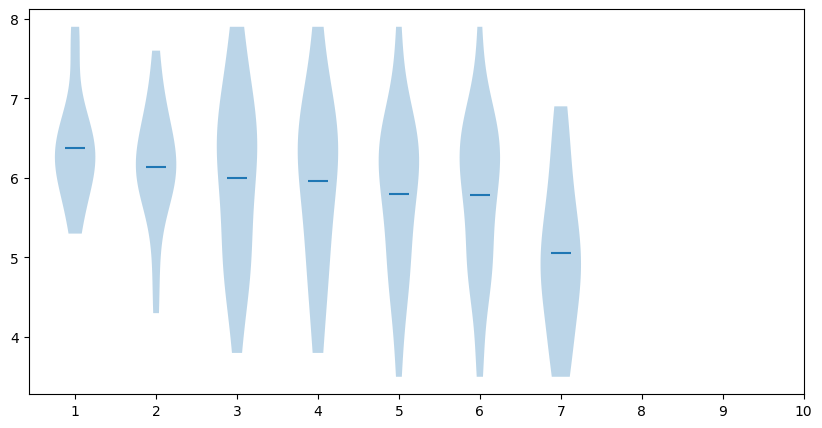

In [152]:
# Plot the top 10 genres by year
widget = widgets.IntSlider(min=1900, max=2019, step=1, value=1900)
def plot_top10_by_year(year):
    top10 = sorted(genre_rates_by_year[year].items(), key=lambda x: x[1][0], reverse=True)[:10]
    plt.figure(figsize=(10, 5))
    # plt.bar([x[0] for x in top10], [x[1][0] for x in top10])
    plt.violinplot([x[1][3] for x in top10], showmeans=True, showextrema=False)
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in top10])
    # plt.errorbar([x[0] for x in top10], [x[1][0] for x in top10], yerr=[[x[1][0]-x[1][1] for x in top10], [x[1][2]-x[1][0] for x in top10]], fmt='o', color='black')
    plt.xticks(rotation=45)
    plt.ylim(-1, 11)
    plt.title(f"Top 10 genres by average rating in {year}")
    plt.show()

widgets.interact(plot_top10_by_year, year=widget)


In [142]:
# Plot the bottom 10 genres by year
widget = widgets.IntSlider(min=1920, max=2013, step=1, value=2013, description="Year:")
def plot_genre_by_year(year):
    bottom10 = sorted(genre_rates_by_year[year].items(), key=lambda x: x[1][0], reverse=False)[:10]
    plt.figure(figsize=(10, 5))
    plt.bar([x[0] for x in bottom10], [x[1][0] for x in bottom10], label="Average rating")
    plt.errorbar([x[0] for x in bottom10], [x[1][0] for x in bottom10], yerr=[[x[1][0]-x[1][1] for x in bottom10], [x[1][2]-x[1][0] for x in bottom10]], fmt='o', color='black', label="95% confidence interval")
    plt.xticks(rotation=45)
    plt.title(f"Bottom 10 genres by average rating in {year}")
    plt.legend()
    plt.show()

widgets.interact(plot_genre_by_year, year=widget)


interactive(children=(IntSlider(value=2013, description='Year:', max=2013, min=1920), Output()), _dom_classes=…

<function __main__.plot_genre_by_year(year)>

#### Separation into bad, ok and good movies

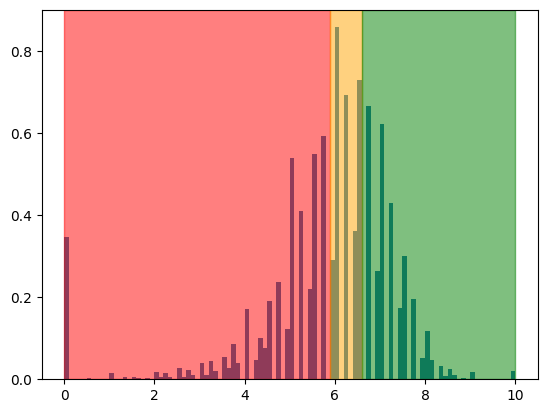

In [175]:
# Distribution of ratings
plt.hist(df_movies["vote_average"], bins=100, density=True)
# color first third of the data
plt.axvspan(0, 5.9, alpha=0.5, color='red')
plt.axvspan(5.9, 6.6, alpha=0.5, color='orange')
plt.axvspan(6.6, 10, alpha=0.5, color='green')
plt.show()

In [176]:
# Split the data into 3 groups
df_movies["rating_group"] = pd.cut(df_movies["vote_average"], bins=[0, 5.9, 6.6, 10], labels=["bad", "average", "good"])

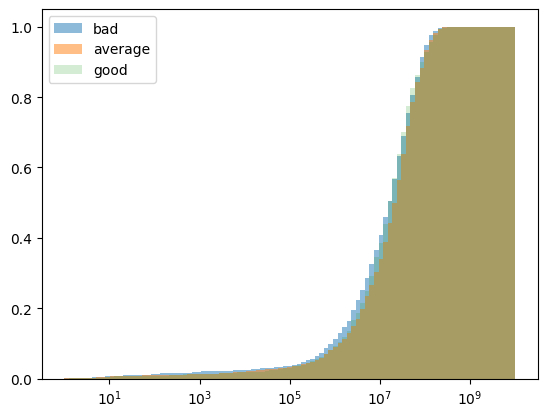

In [177]:
# Plot budget distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["adj_budget"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5)
plt.hist(df_movies[df_movies["rating_group"] == "average"]["adj_budget"], bins=bins, density=True, cumulative=True, label="average", alpha=0.5)
plt.hist(df_movies[df_movies["rating_group"] == "good"]["adj_budget"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.2)
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


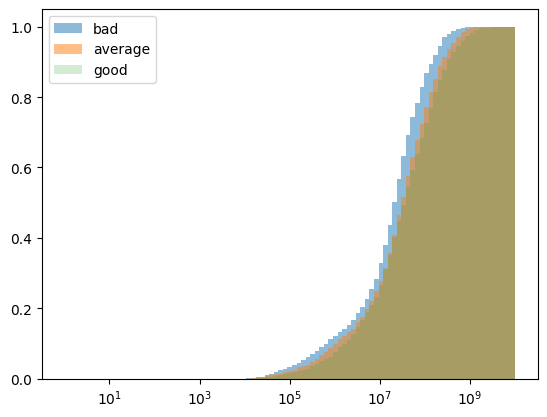

In [178]:
# Plot revenue distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["adj_revenue_x"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5)
plt.hist(df_movies[df_movies["rating_group"] == "average"]["adj_revenue_x"], bins=bins, density=True, cumulative=True, label="average", alpha=0.5)
plt.hist(df_movies[df_movies["rating_group"] == "good"]["adj_revenue_x"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.2)
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


In [179]:
# Cast to bool
# Count adult movies in each group
def aggreate_adult(x):
    if x == "True":
        return True
    else:
        return False

df_movies["is_adult"] = df_movies["adult"].apply(aggreate_adult)
df_movies.groupby("rating_group")["is_adult"].mean() * 100


rating_group
bad        0.019109
average    0.000000
good       0.000000
Name: is_adult, dtype: float64

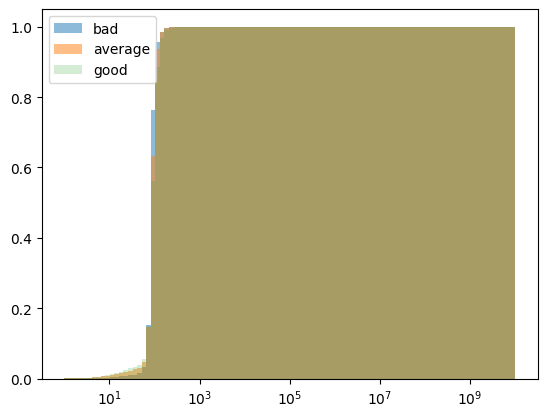

In [180]:
# Plot revenue distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["runtime_x"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5)
plt.hist(df_movies[df_movies["rating_group"] == "average"]["runtime_x"], bins=bins, density=True, cumulative=True, label="average", alpha=0.5)
plt.hist(df_movies[df_movies["rating_group"] == "good"]["runtime_x"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.2)
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()



#### The countries that have bad reviews

In [199]:
def process_countries_languages(x):
    if x is None or pd.isna(x):
        return []
    else:
        return list(json.loads(x).values())

# df_movies["countries"] = df_movies["countries"].apply(process_countries_languages)
df_movies["languages"] = df_movies["languages"].apply(process_countries_languages)
df_movies.head(10)


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,title,video,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],2.143713e+07,tt0228333,False,...,Ghosts of Mars,False,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Horror, Supernatural, Science Fiction, Space ...",2001.0,2001-08-24
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English Language],[United Kingdom],NaN,tt0094320,False,...,White of the Eye,False,5.7,15.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Erotic thriller, Horror, Psychological thrill...",1987.0,1987-01-01
2,6631279,/m/0gffwj,Little city,NaN,93.0,[English Language],[United States of America],NaN,tt0119548,False,...,Little City,False,6.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Comedy, Drama, Romance Film, Romantic drama, ...",1997.0,1997-04-04
3,171005,/m/016ywb,Henry V,10161099.0,137.0,[English Language],[United Kingdom],2.220446e+07,tt0097499,False,...,Henry V,False,7.4,73.0,0.000000e+00,1.966718e+07,-1.966718e+07,"{War, Drama, War film, Period piece, Costume d...",1989.0,1989-11-08
4,77856,/m/0kcn7,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],8.939626e+08,tt0058331,False,...,Mary Poppins,False,7.4,1217.0,8.939626e+08,5.244581e+07,8.415168e+08,"{Comedy, Drama, Musical, Children's/Family, Ch...",1964.0,1964-08-27
5,612710,/m/02wjqm,New Rose Hotel,21521.0,92.0,[English Language],[United States of America],3.500327e+04,tt0133122,False,...,New Rose Hotel,False,5.0,24.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Drama, Erotic thriller, Film adaptation, Futu...",1999.0,1999-10-01
6,21926710,/m/05p45cv,White on Rice,NaN,82.0,[],[United States of America],NaN,tt0892904,False,...,White on Rice,False,6.4,4.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Comedy, Romantic comedy, Romance Film, Romanc...",2009.0,2009-01-01
7,26067101,/m/0b6c_nw,Siam Sunset,NaN,91.0,[],"[Australia, New Zealand]",NaN,tt0178022,False,...,Siam Sunset,False,6.7,6.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Foreign, Comedy, Romance Film, Romantic comed...",1999.0,1999-01-01
8,9548445,/m/02pjlrp,Archie: To Riverdale and Back Again,NaN,100.0,[English Language],[United States of America],NaN,tt0099054,False,...,Archie To Riverdale and Back Again,False,5.5,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Comedy, TV Movie}",1990.0,1990-05-06
9,2314463,/m/0734w5,Electric Apricot: Quest For Festeroo,NaN,96.0,[],[United States of America],NaN,tt0482499,False,...,National Lampoon Presents Electric Apricot: Qu...,False,6.3,3.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Parody, Comedy, Mockumentary}",2006.0,2006-01-01


In [202]:
all_countries = set()

for c in df_movies["countries"]:
    all_countries.update(c)

print("We have in total", len(all_countries), "different countries")
print(all_countries)

We have in total 133 different countries
{'Kenya', 'Lebanon', 'Morocco', 'Israel', 'Senegal', 'Panama', 'Nazi Germany', 'Portugal', 'Taiwan', 'Monaco', 'Northern Ireland', 'Poland', 'Singapore', 'West Germany', 'Czech Republic', 'Peru', 'Japan', 'Romania', 'Sri Lanka', 'Republic of China', 'Qatar', 'Netherlands', 'Serbia and Montenegro', 'German Democratic Republic', 'Egypt', 'Uzbekistan', 'Socialist Federal Republic of Yugoslavia', 'Cuba', 'Russia', 'Democratic Republic of the Congo', 'Ukrainian SSR', 'Malta', 'Czechoslovakia', 'South Korea', 'Malaysia', 'New Zealand', 'Weimar Republic', 'Slovak Republic', 'Kingdom of Italy', 'Albania', 'Puerto Rico', 'Bhutan', 'Bulgaria', 'Australia', 'Montenegro', 'Tunisia', 'Uruguay', 'Iran', 'Jamaica', 'Slovenia', 'Algeria', 'Chile', 'Italy', 'Canada', 'Korea', 'Philippines', 'Colombia', 'Mongolia', 'Denmark', 'Aruba', 'Isle of Man', 'Mandatory Palestine', 'Bahamas', 'Afghanistan', 'Iceland', 'United Arab Emirates', 'Thailand', 'Yugoslavia', 'Arge

In [203]:
# Create a column for each country, language
for c in all_countries:
    df_movies[f"played_in_{c}"] = df_movies["countries"].apply(lambda x: c in x)
df_movies.head(5)

,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,played_in_Bangladesh,played_in_Palestinian Territories,played_in_Mali,played_in_Federal Republic of Yugoslavia,played_in_Serbia,played_in_Turkey,played_in_Cameroon,played_in_Haiti,played_in_Armenia,played_in_Wales
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],2.143713e+07,tt0228333,False,...,False,False,False,False,False,False,False,False,False,False
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English Language],[United Kingdom],NaN,tt0094320,False,...,False,False,False,False,False,False,False,False,False,False
2,6631279,/m/0gffwj,Little city,NaN,93.0,[English Language],[United States of America],NaN,tt0119548,False,...,False,False,False,False,False,False,False,False,False,False
3,171005,/m/016ywb,Henry V,10161099.0,137.0,[English Language],[United Kingdom],2.220446e+07,tt0097499,False,...,False,False,False,False,False,False,False,False,False,False
4,77856,/m/0kcn7,Mary Poppins,102272727.0,139.0,[English Language],[United States of America],8.939626e+08,tt0058331,False,...,False,False,False,False,False,False,False,False,False,False


In [204]:
# Average rate by country
country_rates = dict()
for c in all_countries:
    c_rates = df_movies[df_movies[f"played_in_{c}"]]["vote_average"]
    country_rates[c] = c_rates


0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
                 ...           
172                      Serbia
173                  Montenegro
174                      Kosovo
175         Trinidad and Tobago
176                    S. Sudan
Name: name, Length: 177, dtype: object


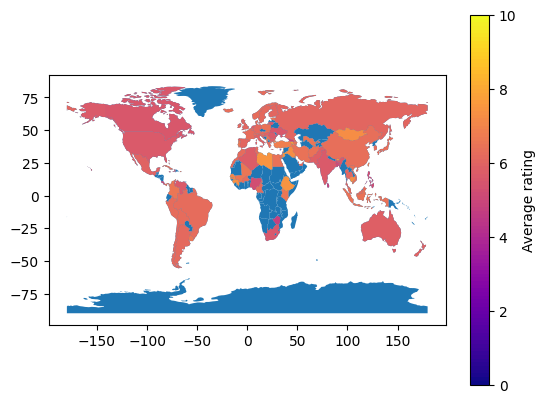

In [249]:
import matplotlib

# World map coloured by vote average
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot()

cmap = matplotlib.colormaps["plasma"].resampled(100)
print(world.name)

for c in country_rates:
    c_rate = country_rates[c].mean()
    if c not in world.name.values:
        continue
    world[world.name == c].plot(color=cmap(c_rate/10),ax=ax)
# plt.set_cmap("plasma")
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 10), cmap=cmap),
             ax=ax, label="Average rating")
plt.show()

### The genres that contain the most bombs

We processed the genres from 300 diferrent genres to 200 genres. We did that by saying for example that if a movie is a Romance Comedy then it is a Romance and a Comedy.

Then we have one hot encoded the presence of each genre in the movies. the result is stored in the dataframe **genres.csv** (this file is generated by the script `genres_study.py`).

In [ ]:
# Read the dataframe
df_genre = pd.read_csv("../data/MovieSummaries/genres.csv", index_col=0)

# Merge with the computed bombs
df_genre = df_genre.merge(df_movies[["wiki_id", "is_bomb_profit", "is_bomb_reviews"]], on="wiki_id")

genre_names = list(set(df_genre.columns).difference(["wiki_id", "freebase_id", "name", "is_bomb_profit", "is_bomb_reviews"]))
count_ratio = []
count_total = []
for gn in genre_names:
    count_failures = df_genre[df_genre["is_bomb_profit"]][gn].sum()
    total = df_genre[gn].sum()
    count_total.append(total)
    count_ratio.append(count_failures / total)

genre_names = np.array(genre_names)
count_ratio = np.array(count_ratio)
count_total = np.array(count_total)

genre_names, count_ratio = genre_names[count_total > 100], count_ratio[count_total > 100]

genre_names = genre_names[np.argsort(-count_ratio)]
count_ratio = count_ratio[np.argsort(-count_ratio)]

plt.figure(figsize=(10, 5))
plt.bar(genre_names[:10], count_ratio[:10]*100)
plt.xticks(rotation=90)
plt.title("Proportion of bombs in each genre based on profit")
plt.ylabel("% of all movies")
plt.show()

In [ ]:
# Same figure considering bar reviews as beeing a failure
count_ratio = []
count_total = []
for gn in genre_names:
    count_failures = df_genre[df_genre["is_bomb_reviews"]][gn].sum()
    total = df_genre[gn].sum()
    count_total.append(total)
    count_ratio.append(count_failures / total)

genre_names = np.array(genre_names)
count_ratio = np.array(count_ratio)
count_total = np.array(count_total)

genre_names, count_ratio = genre_names[count_total > 100], count_ratio[count_total > 100]

genre_names = genre_names[np.argsort(-count_ratio)]
count_ratio = count_ratio[np.argsort(-count_ratio)]

plt.figure(figsize=(10, 5))
plt.bar(genre_names[:10], count_ratio[:10]*100)
plt.title("Proportion of bombs in each genre based on reviews")
plt.ylabel("% of all movies")
plt.xticks(rotation=90)
plt.show()


There are bad movies in every genre but here we have obtained the genres that contains the greatest proportions of failures. And the two list we obtained look very plausible. We can easyly think of a Zombie movie that must be a failure in terms of profit. But now we will analyse more precisely what could make a movie fail.

### Initial analysis of tvtropes effect

For this part, the goal is to explore the associations between the presence of tropes and the indication of box-office bombs. This could be done by doing a logistic regression of the `is_bomb_tvtropes` variable on the one-hot encodings of the tropes and look at the coefficients and the p-values.

In [ ]:
# Retrieve all the tropes from the movies in the dataset
all_tropes = [tr for tropes in df_tropes["trope"].values for tr in tropes if tr != "boxofficebomb"]
# Retrieve all  the tropes from the box-office bomb movies in the dataset
all_tropes_bombs = [tr for tropes in df_tropes["trope"].values for tr in tropes if "boxofficebomb" in tropes and tr != "boxofficebomb"]

# counts the number of movies in each trope
from collections import Counter
counts = Counter(all_tropes)
counts_bombs = Counter(all_tropes_bombs) # only consider bombs

def normalize_counts(counts, normalizing_const=None):
    """Divide the counts by the number of movies
    """
    if normalizing_const is None:
        normalizing_const = sum(counts.values(), 0.0)
    for key in counts:
        counts[key] /= normalizing_const
        counts[key] *= 100
    return counts

def count_movies_with_trope_is_bomb(df_tropes, trope):
    i = 0
    for trope_list in df_tropes["trope"]:
        if trope in trope_list and "boxofficebomb" in trope_list:
            i += 1
    return i

# normalize by the number of movies
counts_n = normalize_counts(counts, df_tropes.shape[0])
counts_bombs_n = normalize_counts(counts_bombs, df_tropes["is_bomb_tvtropes"].sum())

res_all = {}
for k, v in counts.most_common(100):
    res_all[k] = v

top_tropes = list(res_all.keys())

res_bombs = {}
for k, v in counts_bombs.most_common(100):
    res_bombs[k] = v

In [ ]:
dict_plot = {}
for i, trope in enumerate(top_tropes):
    dict_plot[trope] = count_movies_with_trope_is_bomb(df_tropes, trope) / res_all[trope]
dict_plot = {k: v for k, v in sorted(dict_plot.items(), key=lambda item: item[1], reverse=True)}

plt.bar(list(dict_plot.keys())[:10], list(dict_plot.values())[:10])
plt.xticks(rotation=90)
plt.ylabel("% of all movies with the trope")
plt.title("% of bombed movies in each of the top tropes")
plt.show()

Comment: These tropes are the ones that contain the most bombed movies. We can see that these tropes make a lot of sense when one checks their definitions on tvtropes.org.

In [ ]:
features_list = top_tropes

trope_ind_mat = np.zeros((len(df_tropes), len(features_list)))

for i, trope in enumerate(features_list):
    trope_indicator = []
    for trope_list in df_tropes["trope"].values:
        trope_indicator.append(trope in trope_list)
    trope_ind_mat[:, i] = trope_indicator
trope_ind_mat = pd.DataFrame(trope_ind_mat, columns=features_list)

model = sm.Logit(df_tropes["is_bomb_tvtropes"].values, sm.add_constant(trope_ind_mat))
res = model.fit()

res.params[res.pvalues[res.pvalues < 0.05/100].index].sort_values(ascending=False)

Unhide the cell below to see the full results of the regression. In short, there are a few tropes that have strong effects (possibly causal) on the failure of the movie, but these tropes are not present in the trope plot above.

#### Full results of the regression

In [ ]:
res.summary()

### Initial analysis of competition effect

It is intuitive to believe that the competition bewteen movies has an effect on the success or failure of a movie. But what is the competition?

#### Extract competition features

The features related to competition we are going to extract (for now) are :
 - the number of movies released the same week
 - the number of movies released the same month
 - the number of movies released the same year

 - the number of movies released the same week of the same genre
 - the number of movies released the same month of the same genre
 - the number of movies released the same year of the same genre

In [ ]:
# Only keep movies with a release date
df_movies_rd = df_movies[~df_movies["release_date"].isna()]

# Count the number of movies per week, month, year 
for period in ["W", "M", "Y"]:
    df_movies_rd["period"] = df_movies_rd["release_date"].apply(lambda x: x.to_period(period))
    df_movies_rd["num_release_this_" + period] = df_movies_rd.groupby("period")["period"].transform("count")
df_movies_rd.drop(columns=["period"], inplace=True)

df_movies_genre_exploded = df_movies_rd.explode(column="genres")

# Count the number of movies per week, month, year of the same genre
for period in ["W", "M", "Y"]:
    df_movies_rd["num_release_this_" + period + "_of_this_genre"] = 0
    df_movies_rd["period"] = df_movies_rd["release_date"].apply(lambda x: x.to_period(period))
    df_movies_genre_exploded["period"] = df_movies_genre_exploded["release_date"].apply(lambda x: x.to_period(period))
    for genre in df_movies_genre_exploded["genres"].unique():
        # imdb_genres_df["num_release_this_" + period + "_of_this_genre"] = merge_df[merge_df["genres"] == genre].groupby("period")["period"].transform("count")
        counts = df_movies_genre_exploded[df_movies_genre_exploded["genres"] == genre].groupby("period")["id"].nunique()
        df_movies_rd["num_release_this_" + period + "_of_this_genre"] = df_movies_rd["period"].apply(lambda x: counts[x] if x in counts else 0)

df_movies_rd.drop(columns=["period"], inplace=True)
del df_movies_genre_exploded


#### Linear regression with competition features

Now we are going to train a linar model to predict wether a movie is a bomb or not using the previously extracted features. In that way we will ser the effect of competition or not on being a bomb.

After som features selection, we came out with the following model

In [ ]:
# test_features = ["num_release_this_W", "num_release_this_M", "num_release_this_Y", "num_release_this_W_of_this_genre", "num_release_this_M_of_this_genre", "num_release_this_Y_of_this_genre"]
test_features = ["num_release_this_W_of_this_genre",  "num_release_this_Y_of_this_genre"]
control_features = ["adj_budget", "popularity", "vote_average", "vote_count", "num_release_this_W", "num_release_this_Y"]
target_features = ["is_bomb_profit", "is_bomb_reviews"]

# Get the features
x = df_movies_rd[test_features + control_features + target_features]
x.dropna(inplace=True)

y_profit = x["is_bomb_profit"]
y_reviews = x["is_bomb_reviews"]
x = x[test_features + control_features].astype(np.float32)
for f in x.columns:
    x[f] = (x[f] - x[f].min()) / (x[f].max() - x[f].min())

# Cast to float32
x = x.astype(np.float32)
y_reviews = y_reviews.astype(np.float32)
y_profit = y_profit.astype(np.float32)

# Fit the model
x =sm.add_constant(x)
print(len(x))

##### Linear model that predict bombs based on profit

In [ ]:
model = sm.OLS(y_profit, x).fit()
model.summary()

##### Linear model that predict bombs based on reviews

In [ ]:
model = sm.OLS(y_reviews, x).fit()
model.summary()

Both models seem to capture some relationship between the features and the targets because their F-statistics are significant. In both models, grouping by genres do not seem to help, but no grouping provides significant features (the number of movies released in the same year and week). This means that the competition effect makes a movie more likely to fail (beacause the coefficients are positive).

### Quick study of the plots

In that part we used a pretrained language model in order to extract embeddings from movie plots.

We hoped that we could extract relevent informations from those embeddings. We first trained a SVM on the embeddings to predict if a movie is a bomb or not. The result was not conclusive.

Then we represented the embeddings in two dimensions in order to see if we identify clusters

In [ ]:
with open("../data/MovieSummaries/plots_embeddings_mpnet.pkl", "rb") as f:
    plot_embeddings_mapping = pickle.load(f)

plots_df = get_plot_summaries()
plots_df = plots_df.merge(df_movies[["wiki_id", "is_bomb_profit", "is_bomb_reviews", "genres"]], on="wiki_id")

In [ ]:
# Get a 2D representation of the plot embeddings
pca = PCA(n_components=2)
keys, embeddings = [], []
for k, e in plot_embeddings_mapping.items():
    keys.append(k)
    embeddings.append(e)

fitted_repr = pca.fit_transform(embeddings)
print("Explained variance ratio", sum(pca.explained_variance_ratio_))

plot_embeddings_mapping_x = {}
plot_embeddings_mapping_y = {}
for key, e in zip(keys, fitted_repr):
    plot_embeddings_mapping_x[key] = e[0]
    plot_embeddings_mapping_y[key] = e[1]

plots_df["x"] = plots_df["wiki_id"].map(plot_embeddings_mapping_x)
plots_df["y"] = plots_df["wiki_id"].map(plot_embeddings_mapping_y)


In [ ]:
# Plot the 2D representation of the plot embeddings
plots_df.plot.scatter(x="x", y="y", figsize=(10, 10))
plt.show()

In [ ]:
# Color by box office bomb
fig = plt.figure(figsize=(10, 10))
plots_df[plots_df["is_bomb_profit"]].plot.scatter(x="x", y="y", color="red", ax=fig.gca())
plots_df[~plots_df["is_bomb_profit"]].plot.scatter(x="x", y="y", color="blue", ax=fig.gca(), alpha=0.1)

plt.show()

We could not identify any obvious clusters, even after coloring the datapoints by our features (by genre, being a bomb or not, and by year).

### What about actors


In [181]:
df_actors = get_characters()
df_actors.columns

Index(['wiki_id', 'movie_freebase_id', 'release_date', 'character_name',
       'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity',
       'actor_name', 'actor_age', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

In [182]:
df_actors = df_actors.merge(df_movies[["wiki_id", "is_bomb_profit", "is_bomb_reviews"]], on="wiki_id") 
df_actors["nb_bomb_reviews"] = df_actors.groupby(["actor_name", "actor_dob"])["is_bomb_reviews"].transform("sum")
df_actors.head(5)

,wiki_id,movie_freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,is_bomb_profit,is_bomb_reviews,nb_bomb_reviews
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,True,False,0.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,True,False,1.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,True,False,0.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,True,False,1.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,True,False,2.0


<AxesSubplot: >

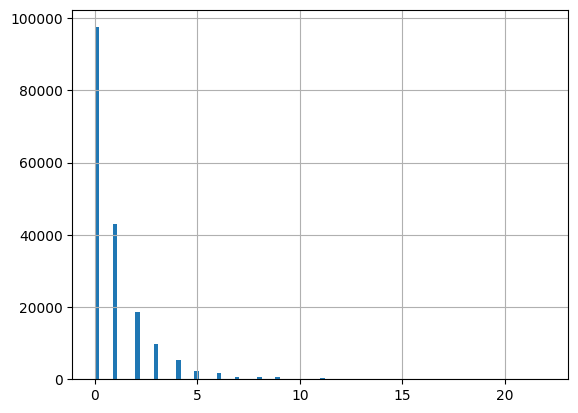

In [8]:
df_actors["nb_bomb_reviews"].hist(bins=100)

In [9]:
df_actors["release_date"] = pd.to_datetime(df_actors["release_date"], format="%Y-%m-%d", errors="coerce")
df_movies["release_date"] = pd.to_datetime(df_movies["release_date"], format="%Y-%m-%d", errors="coerce")

In [ ]:
print(len(df_actors))
counter = 0
# Number of movie bombs before the movie
def count_bombs_before(row):
    global counter
    counter += 1
    if counter % 1000 == 0:
        print(counter, f"{counter/232316*100:.3f}%", end="\r")
    date_of_release = row["release_date"]
    movies_before = df_actors[["actor_name", "actor_dob", "release_date", "is_bomb_reviews"]][(df_actors["actor_name"] == row["actor_name"]) & (df_actors["actor_dob"] == row["actor_dob"])]
    count = movies_before[movies_before["release_date"] < date_of_release]["is_bomb_reviews"].sum()
    return count
df_actors["nb_bomb_reviews_before"] = df_actors.apply(count_bombs_before, axis=1)

In [ ]:
# Does the number of bombs before the movie affect the number of bombs after the movie?
# df_actors["nb_bomb_reviews_before"].hist(bins=100)
df_actors[["nb_bomb_reviews_before", "is_bomb_reviews"]].corr()


In [19]:
df_actors.columns

Index(['wiki_id', 'movie_freebase_id', 'release_date', 'character_name',
       'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity',
       'actor_name', 'actor_age', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'is_bomb_profit',
       'is_bomb_reviews', 'nb_bomb_reviews'],
      dtype='object')

In [38]:
# Number of movie bombs before the movie
actors = df_actors.groupby(["freebase_actor_id"])
nb_after = []
for actor, actor_df in actors:
    if actor_df.is_bomb_reviews.sum() == 1:
        actor_df = actor_df.sort_values("release_date")["is_bomb_reviews"].values
        index_of_bomb = np.where(actor_df)[0][-1]
        nb_after.append(len(actor_df) - index_of_bomb - 1)


1.9033723065030437
64
0


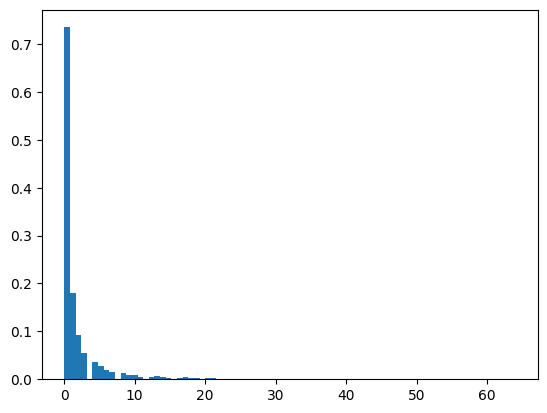

In [39]:
print(np.mean(nb_after))
print(np.max(nb_after))
print(np.min(nb_after))
plt.hist(nb_after, bins=80, density=True)
plt.show()

In [ ]:
# Has is ended their career?
df_actors["nb_movie"] = df_actors.groupby(["actor_name", "actor_dob"])["wiki_id"].transform("count")

# Colored histogram by having played in a bomb
# In proportion
fig = plt.figure(figsize=(10, 10))
df_actors[df_actors["is_bomb_reviews"]].nb_movie.hist(bins=100, ax=fig.gca(), color="red", density=True, alpha=0.3)
df_actors[~df_actors["is_bomb_reviews"]].nb_movie.hist(bins=100, ax=fig.gca(), color="blue", alpha=0.3, density=True)

In [ ]:
from scipy.stats import ttest_ind

print(df_actors[df_actors["is_bomb_reviews"]].nb_movie.mean())
print(df_actors[~df_actors["is_bomb_reviews"]].nb_movie.mean())

print(ttest_ind(df_actors[df_actors["is_bomb_reviews"]].nb_movie.dropna(), df_actors[~df_actors["is_bomb_reviews"]].nb_movie.dropna()))
